# **NYC Taxi Duration Prediction**

**Installing Required Libraries**

In [1]:
!pip install geopy holidays optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 20.8 MB/s eta 0:00:00


**Importing Libraries**

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from geopy.distance import geodesic
import holidays
import datetime

# **DATA PRE-PROCESSING**

**Load and Inspect Dataset**

In [ ]:
# Upload your local CSV file (nyc_taxi_trip_duration.csv.zip)
from google.colab import files
uploaded = files.upload()

In [3]:
# Step 2: Unzip the uploaded file
import zipfile
import os

zip_path = "nyc_taxi_trip_duration.csv.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

# Step 3: Load the extracted CSV
import pandas as pd

csv_file = "nyc_taxi_trip_duration.csv"
df = pd.read_csv(csv_file)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (729322, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  729322 non-null  object 
 1   vendor_id           729322 non-null  int64  
 2   pickup_datetime     729322 non-null  object 
 3   dropoff_datetime    729322 non-null  object 
 4   passenger_count     729322 non-null  int64  
 5   pickup_longitude    729322 non-null  float64
 6   pickup_latitude     729322 non-null  float64
 7   dropoff_longitude   729322 non-null  float64
 8   dropoff_latitude    729322 non-null  float64
 9   store_and_fwd_flag  729322 non-null  object 
 10  trip_duration       729322 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 61.2+ MB


**Data Pre-Processing: Missing Data**

In [5]:
# Data Shape
print('Data Shape',df.shape)
df.info()

Data Shape (729322, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  729322 non-null  object 
 1   vendor_id           729322 non-null  int64  
 2   pickup_datetime     729322 non-null  object 
 3   dropoff_datetime    729322 non-null  object 
 4   passenger_count     729322 non-null  int64  
 5   pickup_longitude    729322 non-null  float64
 6   pickup_latitude     729322 non-null  float64
 7   dropoff_longitude   729322 non-null  float64
 8   dropoff_latitude    729322 non-null  float64
 9   store_and_fwd_flag  729322 non-null  object 
 10  trip_duration       729322 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 61.2+ MB


Based on the entry totals above, there are no missing observations to be imputed.

**Data Pre-Processing: Outliers**

In [6]:
# Statistical summary
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vendor_id,729322.0,1.535403,0.498745,1.000000,1.000000,2.000000,2.000000,2.000000e+00
passenger_count,729322.0,1.662055,1.312446,0.000000,1.000000,1.000000,2.000000,9.000000e+00
pickup_longitude,729322.0,-73.973513,0.069754,-121.933342,-73.991859,-73.981758,-73.967361,-6.589738e+01
pickup_latitude,729322.0,40.750919,0.033594,34.712234,40.737335,40.754070,40.768314,5.188108e+01
dropoff_longitude,729322.0,-73.973422,0.069588,-121.933304,-73.991318,-73.979759,-73.963036,-6.589738e+01
dropoff_latitude,729322.0,40.751775,0.036037,32.181141,40.735931,40.754509,40.769741,4.392103e+01
trip_duration,729322.0,952.229133,3864.626197,1.000000,397.000000,663.000000,1075.000000,1.939736e+06


**passenger_count**                                      
The passenger_count variable has a minimum value of 0 passengers, which does not make sense in the context of this business case. These observations are most likely errors and will need to removed from the dataset.

Another red flag is that passenger_count has a maximum value of 9 passengers - highly unlikely for an NYC taxicab. According to the NYC Taxi & Limousine Commission, the maximum number of people allowed in a yellow taxicab, by law, is five passengers (in a five passenger taxicab). There are exceptions for passengers under the age of 7 who may sit on an adult's lap. However, it is unlikely that a full 5 person taxi cab would have that many children under the age of 7 on board to yield a passenger count as high as 9. This observation is likely an error and will also to be removed from the dataset.

In [7]:
# Remove passenger_count outliers
df = df[df['passenger_count'] > 0]
df = df[df['passenger_count'] < 9]

**Longitude and Latitude Coordinates**                           
Based on different coordinate estimates of New York City, the latitude and longitude ranges are as follows:

Latitude is between 40.7128 and 40.748817
Longitude is between - 74.0059 and - 73.968285
The statisical summary of pick-up and drop-off coordinates show max and min observations that fall outside of the NYC city coordinate range. I will exclude these data points as this analysis is limited to New York City proper.

In [8]:
# Remove coordinate outliers
df = df[df['pickup_longitude'] <= -73.75]
df = df[df['pickup_longitude'] >= -74.03]
df = df[df['pickup_latitude'] <= 40.85]
df = df[df['pickup_latitude'] >= 40.63]
df = df[df['dropoff_longitude'] <= -73.75]
df = df[df['dropoff_longitude'] >= -74.03]
df = df[df['dropoff_latitude'] <= 40.85]
df = df[df['dropoff_latitude'] >= 40.63]

**trip_duration**                                                   
Lastly, there are unusual observations present in our target variable, trip_duration. A max trip_duration of 3526282.00 sec (~ 980 hours) is not a realistic trip time - a clear indication that outliers are present in the data

In [9]:
# Remove trips shorter than 1 min or longer than 24 hours (outliers)
df = df[(df['trip_duration'] >= 60) & (df['trip_duration'] <= 86400)]

**Data Pre-Processing: Data Types**

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 715653 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  715653 non-null  object 
 1   vendor_id           715653 non-null  int64  
 2   pickup_datetime     715653 non-null  object 
 3   dropoff_datetime    715653 non-null  object 
 4   passenger_count     715653 non-null  int64  
 5   pickup_longitude    715653 non-null  float64
 6   pickup_latitude     715653 non-null  float64
 7   dropoff_longitude   715653 non-null  float64
 8   dropoff_latitude    715653 non-null  float64
 9   store_and_fwd_flag  715653 non-null  object 
 10  trip_duration       715653 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 65.5+ MB


The pickup and dropoff timestamp variables are being treated as non-null objects. These features should be specified as date objects to allow for easier feature engineering and analysis later on.

In [11]:
# Convert datetime columns
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [12]:
# Confirm changes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 715653 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  715653 non-null  object        
 1   vendor_id           715653 non-null  int64         
 2   pickup_datetime     715653 non-null  datetime64[ns]
 3   dropoff_datetime    715653 non-null  datetime64[ns]
 4   passenger_count     715653 non-null  int64         
 5   pickup_longitude    715653 non-null  float64       
 6   pickup_latitude     715653 non-null  float64       
 7   dropoff_longitude   715653 non-null  float64       
 8   dropoff_latitude    715653 non-null  float64       
 9   store_and_fwd_flag  715653 non-null  object        
 10  trip_duration       715653 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 65.5+ MB


**Data Pre-Processing: Feature Engineering**

The pickup_datetime and dropoff_datetime variables both combine date and time observations into the same column. I will delimit this date and time information into separate columns to allow for easier analysis downstream.

The hour and day of week a passenger is picked up may influence trip duration so I will extract these features from the pickup_datetime variable also. This is not necessary for dropoff_datetime because, logically, the day and hour a passenger is dropped off would have no bearing on trip_duration because this is information is recorded after the trip is completed.

In [13]:
# Delimit pickup_datetime variable
df['pickup_date'] = df['pickup_datetime'].dt.date  # Extract date
df['pickup_time'] = df['pickup_datetime'].dt.time  # Extract time

# Delimit dropoff_datetime variables
df['dropoff_date'] = df['dropoff_datetime'].dt.date  # Extract date
df['dropoff_time'] = df['dropoff_datetime'].dt.time  # Extract time

# Additional pickup features
df['pickup_month'] = df['pickup_datetime'].dt.month  # Extract month
# df['pickup_month'] = df.pickup_datetime.dt.to_period('M')  # Extract yearmonth
# df['pickup_YYYYMM'] = df['pickup_datetime'].apply(lambda x: x.strftime('%Y%m'))  # Extract yearmonth
df['pickup_hour'] = df['pickup_datetime'].dt.hour  # Extract hour
df['pickup_weekday'] = df['pickup_datetime'].dt.dayofweek  # Extract day of week

# Drop concatenated timestamp columns
df.drop(['pickup_datetime'], axis=1, inplace=True)
df.drop(['dropoff_datetime'], axis=1, inplace=True)

# Confirm changes
df.columns

Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'pickup_time',
       'dropoff_date', 'dropoff_time', 'pickup_month', 'pickup_hour',
       'pickup_weekday'],
      dtype='object')

In [14]:
df.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_time,dropoff_date,dropoff_time,pickup_month,pickup_hour,pickup_weekday
0,id1080784,2,1,-73.953918,40.778873,-73.963875,40.771164,N,400,2016-02-29,16:40:21,2016-02-29,16:47:01,2,16,0
1,id0889885,1,2,-73.988312,40.731743,-73.994751,40.694931,N,1100,2016-03-11,23:35:37,2016-03-11,23:53:57,3,23,4
2,id0857912,2,2,-73.997314,40.721458,-73.948029,40.774918,N,1635,2016-02-21,17:59:33,2016-02-21,18:26:48,2,17,6
3,id3744273,2,6,-73.961670,40.759720,-73.956779,40.780628,N,1141,2016-01-05,09:44:31,2016-01-05,10:03:32,1,9,1
4,id0232939,1,1,-74.017120,40.708469,-73.988182,40.740631,N,848,2016-02-17,06:42:23,2016-02-17,06:56:31,2,6,2


In [15]:
#Add Haversine Distance
from geopy.distance import geodesic
import numpy as np

def haversine(row):
    return geodesic(
        (row['pickup_latitude'], row['pickup_longitude']),
        (row['dropoff_latitude'], row['dropoff_longitude'])
    ).km

df['haversine_distance'] = df.apply(haversine, axis=1)
df['log_haversine_distance'] = np.log1p(df['haversine_distance'])

In [16]:
#Add Public Holiday Flag
import holidays

# Load US holidays for New York (NY) in 2016
us_holidays = holidays.US(state='NY', years=2016)

# Extract whether the pickup date is a holiday
df['is_holiday'] = df['pickup_date'].apply(lambda x: x in us_holidays).astype(int)

In [17]:
#Encode categorical features
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

In [18]:
df.drop(columns=['haversine_distance'], inplace=True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 715653 entries, 0 to 729321
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      715653 non-null  object 
 1   vendor_id               715653 non-null  int64  
 2   passenger_count         715653 non-null  int64  
 3   pickup_longitude        715653 non-null  float64
 4   pickup_latitude         715653 non-null  float64
 5   dropoff_longitude       715653 non-null  float64
 6   dropoff_latitude        715653 non-null  float64
 7   store_and_fwd_flag      715653 non-null  int64  
 8   trip_duration           715653 non-null  int64  
 9   pickup_date             715653 non-null  object 
 10  pickup_time             715653 non-null  object 
 11  dropoff_date            715653 non-null  object 
 12  dropoff_time            715653 non-null  object 
 13  pickup_month            715653 non-null  int32  
 14  pickup_hour             7

# **EXPLORATORY DATA ANALYSIS**

**Target Variable: trip_duration**

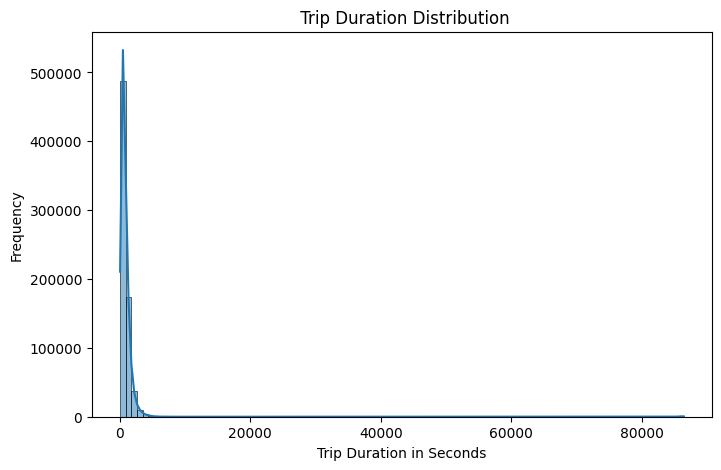

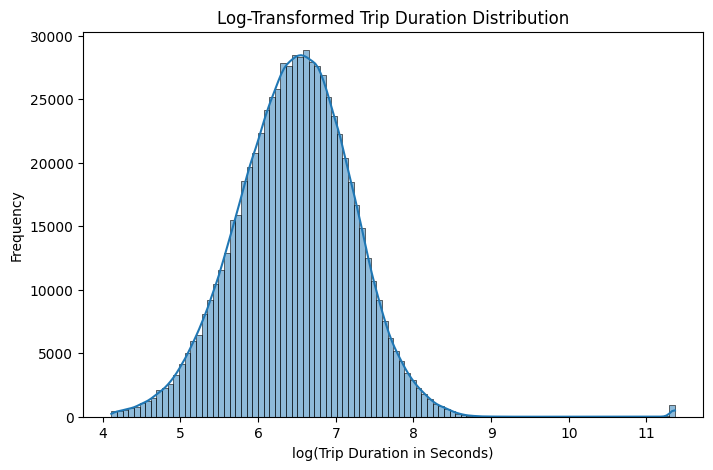

In [ ]:
#Trip Duration Distribution (after log transform)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(8,5))
sns.histplot(df['trip_duration'], bins=100, kde=True)
plt.title(' Trip Duration Distribution')
plt.xlabel('Trip Duration in Seconds')
plt.ylabel('Frequency')
plt.show()
print()
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(df['trip_duration']), bins=100, kde=True)
plt.title('Log-Transformed Trip Duration Distribution')
plt.xlabel('log(Trip Duration in Seconds)')
plt.ylabel('Frequency')
plt.show()

The original trip_duration was highly right-skewed due to a few very long trips. After applying a log transformation, the distribution became more normalized and balanced, reducing the impact of extreme values.









**Feature Variables**

he remaining columns in our dataset are the 'feature variables'. These are the variables that will be fed into our machine learning model to predict the dependent variable, trip_duration. I will explore each one of these features to better understand the information it contains and what transformations are needed before we can proceed to the learning process.

In [ ]:
# Feature names
df.columns

Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'pickup_time',
       'dropoff_date', 'dropoff_time', 'pickup_month', 'pickup_hour',
       'pickup_weekday', 'haversine_distance', 'log_haversine_distance',
       'is_holiday'],
      dtype='object')

**Id**                                               
The id variable is a unique identifier of each trip. I will explore how this feature varies over time (if at all).

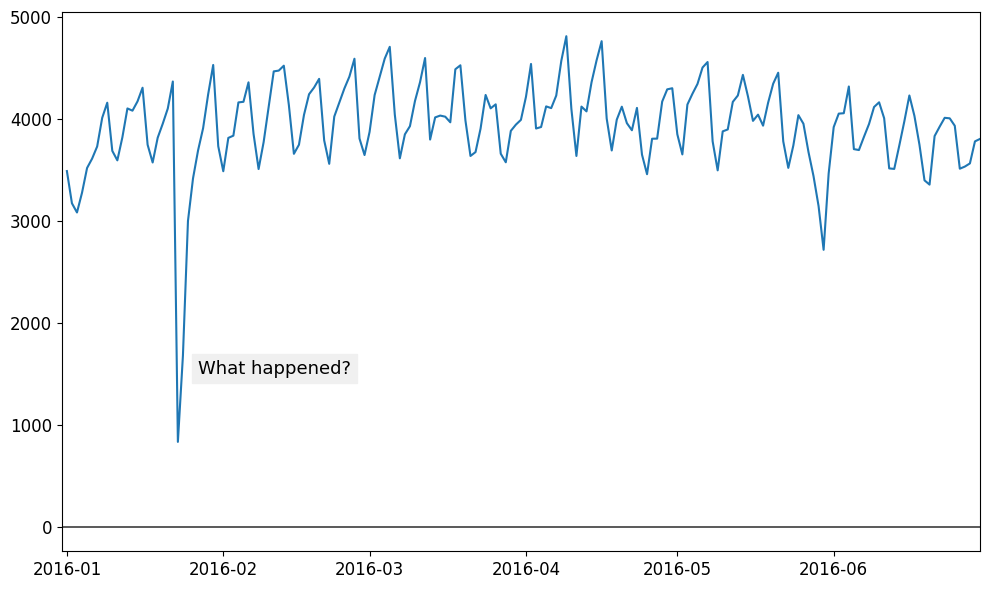

In [ ]:
# Summarize total trips by day
pickups_by_day = df.groupby('pickup_date')['id'].count()

# Create graph
fig, ax = plt.subplots(figsize=(10, 6))
pickups_by_day.plot(ax=ax, legend=False)

# Customize tick size
ax.tick_params(axis='both', which='major', labelsize=12)

# Bold horizontal line at y = 0
ax.axhline(y=0, color='black', linewidth=1.3, alpha=.7)

# Add an extra vertical line by tweaking the range of the x-axis
ax.set_xlim(left=pd.to_datetime('2015-12-31'), right=pd.to_datetime('2016-06-30'))

# Remove x-axis label
ax.set_xlabel("")

# Annotate specific date
ax.text(x=pd.to_datetime('2016-01-27'), y=1500,
        s='What happened?', fontsize=13, rotation=0,
        backgroundcolor='#f0f0f0')

# Show plot
plt.tight_layout()
plt.show()

**Dramatic drop in total trips in late January or early February**

**Trip Id Over Time**                                           
There is a unusual drop in the total number of id around late January. At first glance, it is easy to assume that this could be just seasonality. However, the decrease is much more drastic relative to other winter days before/after the drop and looks to be isolated around a single day. Thus, a more plausible explanation for this outlier could be order entry error or some other extraneous event.



In [ ]:
# Identify where drop occured
df.groupby('pickup_date')['id'].count().sort_values(ascending=True).iloc[[0]]

,id
pickup_date,
2016-01-23,832


Upon further investigation, the drop occured on January 23, 2016 - the date of New York's first big snow storm of the year, where they were hit with 26.8 inches of snowfall. Although there was a significant decline in the overall number of taxi rides, the median trip_duration of the rides that were given that day of 456.5 seconds does not seem to be out of the ordinary.

Although the id variable provides interesting insight about trips over time, the actual Id of a trip record will not be useful in predicting trip_duration in our alogrithm. Thus, I will remove this feature when it comes time to train the model.

**Passenger Count**


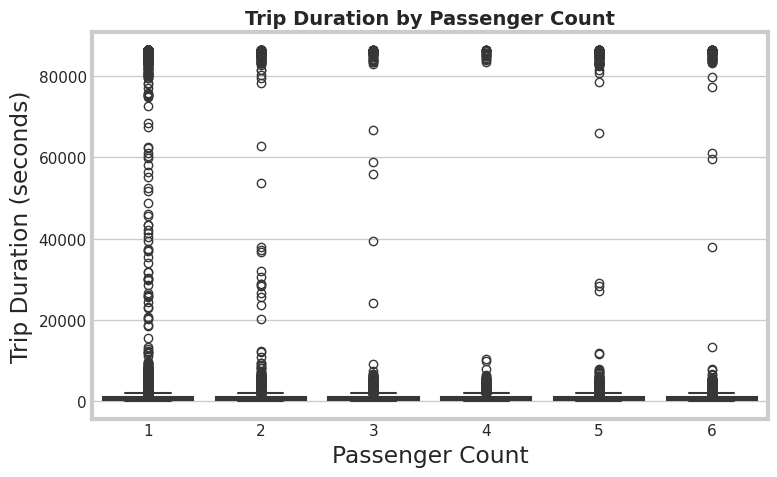

passenger_count,1,2,3,4,5,6
count,507487.000000,103113.000000,29193.000000,13806.000000,38301.000000,23753.000000
mean,910.756559,983.420539,1011.231083,1001.467043,1076.957547,1080.775902
std,2850.592904,3169.374761,3622.496367,3364.367997,4540.459875,4602.486682
min,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
25%,393.000000,414.000000,417.000000,423.000000,399.000000,401.000000
50%,652.000000,684.000000,681.000000,696.000000,664.000000,657.000000
75%,1049.000000,1105.000000,1097.000000,1113.000000,1073.000000,1067.000000
max,86391.000000,86363.000000,86365.000000,86329.000000,86367.000000,86369.000000


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# Minimal and warning-free boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df,
    x='passenger_count',
    y='trip_duration',
    hue='passenger_count',  # Fixes the warning
    palette='coolwarm',
    linewidth=1.5,
    legend=False            # Suppress unnecessary legend
)

plt.title("Trip Duration by Passenger Count", fontsize=14, weight='bold')
plt.xlabel("Passenger Count")
plt.ylabel("Trip Duration (seconds)")
plt.tight_layout()
plt.show()

# Statistical summary
df.groupby('passenger_count')['trip_duration'].describe().transpose()

Passenger count doesn't have much impact on trip duration. The majority of taxi rides are made with 1 passenger, accounting for over half a million trips. As the number of passengers increases, the number of trips decreases significantly. Despite differences in passenger count, the median trip duration remains fairly consistent—around 11 minutes (650–700 seconds)—indicating that trip time is not heavily influenced by how many passengers are in the cab.

However, the mean is higher than the median across all passenger counts, and the standard deviation is quite large—especially for higher passenger counts—revealing the presence of outliers or unusually long trips. For instance, all groups show maximum durations exceeding 86,000 seconds (over 24 hours), which are likely anomalies or data entry issues.

Overall, while most trips are short and similar in duration, the data is positively skewed due to a few extremely long trips in each group.

**Trip Duration by Pickup Hour and Day**                             
I suspect that trips are longer on the weekends due to higher traffic levels, but will need to explore if there are other times during the week trip duration is higher than averag

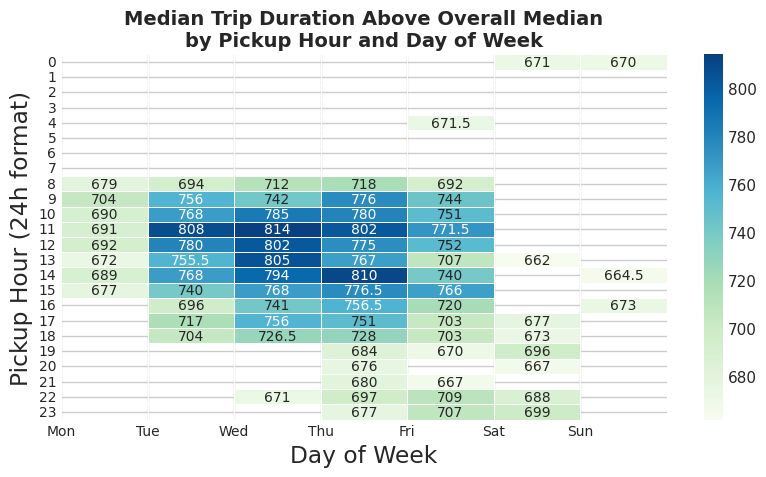

In [ ]:
#Median Trip Duration by Pickup Hour and Day of Week
trip_duration_median = df['trip_duration'].median()

plt.figure(figsize=(8.5, 5))
pickup_hourday = df.groupby(['pickup_hour', 'pickup_weekday'])['trip_duration'].median().unstack()

sns.heatmap(pickup_hourday[pickup_hourday > trip_duration_median],
            linewidths=0.5, annot=True, cmap='GnBu', fmt='g', annot_kws={"size": 10})

# Set custom tick labels
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=10)
plt.yticks(fontsize=10)

# Axis labels
plt.ylabel('Pickup Hour (24h format)')
plt.xlabel('Day of Week')
plt.title('Median Trip Duration Above Overall Median\nby Pickup Hour and Day of Week', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()


Trips tend much longer than the median trip_duration of 655 seconds during the following parts of the week:

Monday - Thursday Office Hours: 8:00 am - 6:00 pm                                 
Thursday, Friday, Saturday Nights: 6:00 pm - midnight                                
Early Saturday & Sunday Mornings: 12:00 am - 1:00 am                                    
Sunday Afternoons: 2:00 pm and 4:00 pm

**Plot Rides**

Next, I will plot the pickup and drop off points of each taxi ride.

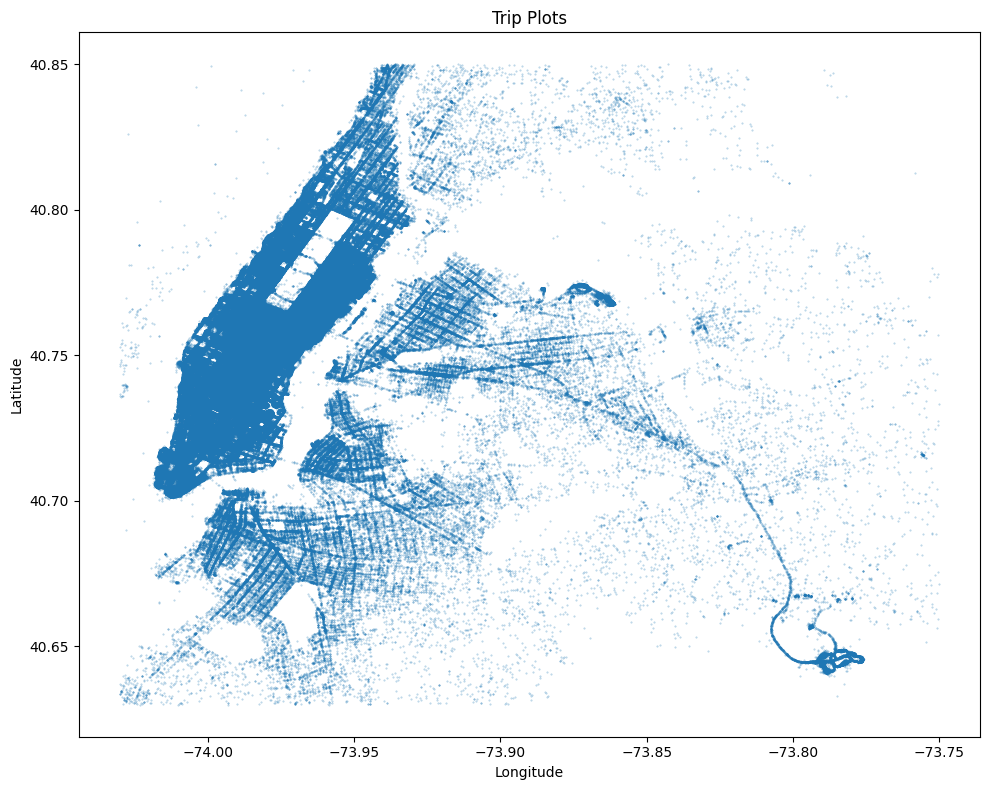

In [ ]:
# Combine pickup and dropoff coordinates
longitude = list(df['pickup_longitude']) + list(df['dropoff_longitude'])
latitude = list(df['pickup_latitude']) + list(df['dropoff_latitude'])

# Plot the trip coordinates
plt.figure(figsize=(10, 8))
plt.plot(longitude, latitude, '.', alpha=0.4, markersize=0.8)
plt.title('Trip Plots')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

**Plot by Neighborhood**


Using the KMeans alogirthm, we can cluster the data points into the different neighborhoods of NYC.

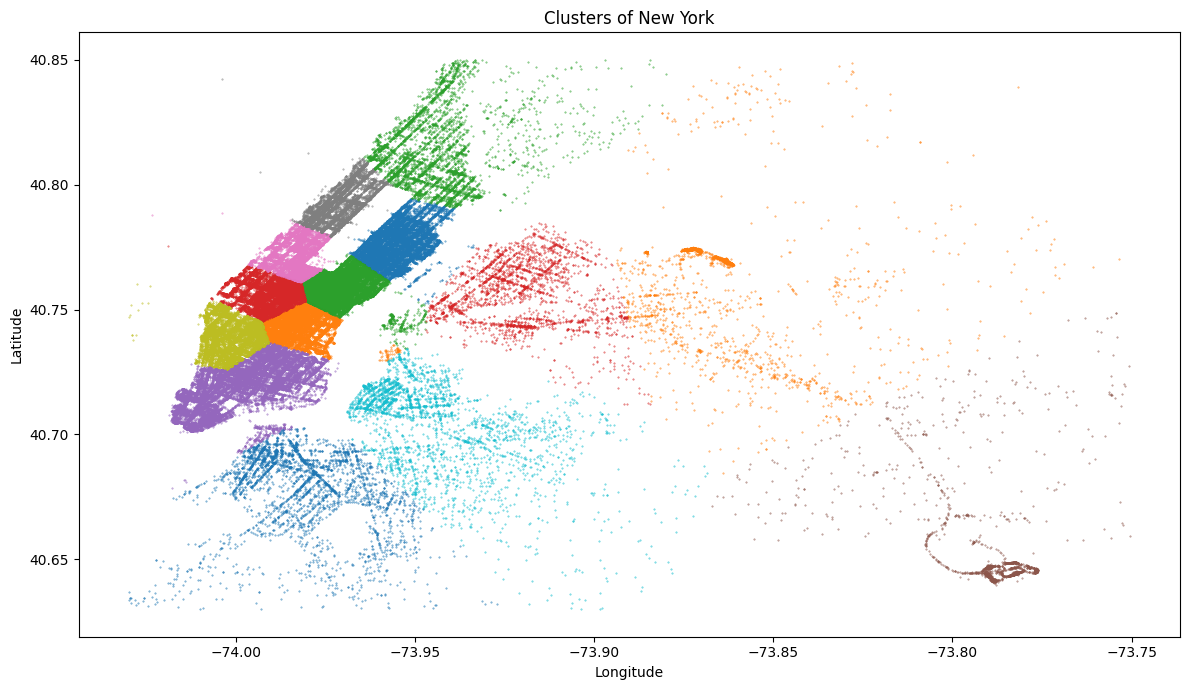

In [ ]:
# Create data frame of coordinates from df
loc_df = pd.DataFrame()
loc_df['longitude'] = list(df['pickup_longitude']) + list(df['dropoff_longitude'])
loc_df['latitude'] = list(df['pickup_latitude']) + list(df['dropoff_latitude'])

# Apply KMeans clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=2, n_init=10)
loc_df['label'] = kmeans.fit_predict(loc_df[['longitude', 'latitude']])

# Sample to reduce points for visualization
loc_sample = loc_df.sample(200000, random_state=2)

# Plot clusters
plt.figure(figsize=(12, 7))
for label in loc_sample['label'].unique():
    plt.plot(
        loc_sample['longitude'][loc_sample['label'] == label],
        loc_sample['latitude'][loc_sample['label'] == label],
        '.', alpha=0.8, markersize=0.8
    )
plt.title('Clusters of New York')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()


**Relationships Between Variables**                                      
Now that each feature has been explored individually, I will examine how they relate to the target variable as well as each other. Variables that are highly correlated (correlation cofficient >.70) are likely to convey redudant information and can be removed from the dataset. Reducing the data's dimentionality in this way will make the data easier to work with and allow for better model results.

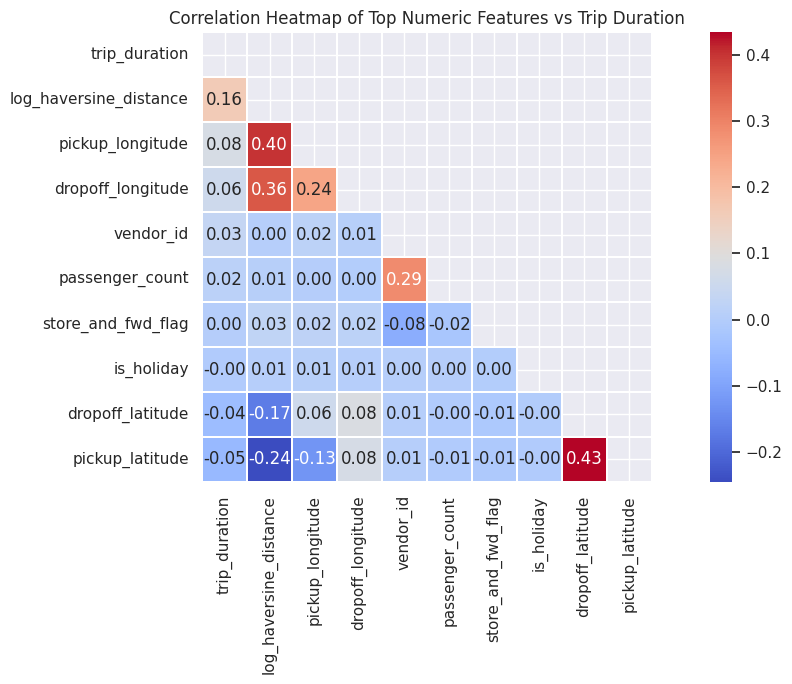

In [ ]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
corrmat = numeric_df.corr()

# Proceed with top-k correlations
plt.figure(figsize=(12, 7))
k = min(76, len(corrmat.columns))  # avoid overflow
cols = corrmat.nlargest(k, 'trip_duration')['trip_duration'].index
cm = np.corrcoef(df[cols].values.T)

# Create upper triangle mask
mask = np.triu(np.ones_like(cm, dtype=bool))

# Plot heatmap
sns.set(font_scale=1)
sns.heatmap(cm, mask=mask, cbar=True, annot=True, square=True,
            fmt='.2f', annot_kws={'size': 12},
            yticklabels=cols.values, xticklabels=cols.values,
            cmap='coolwarm', lw=0.1)

plt.title("Correlation Heatmap of Top Numeric Features vs Trip Duration")
plt.tight_layout()
plt.show()

**Scaling the Features**

In [20]:
df.columns

Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'pickup_time',
       'dropoff_date', 'dropoff_time', 'pickup_month', 'pickup_hour',
       'pickup_weekday', 'log_haversine_distance', 'is_holiday'],
      dtype='object')

In [21]:
# Remove unnecessary features
df.drop(['pickup_date','pickup_time','dropoff_date', 'dropoff_time','id'],
                axis = 1, inplace = True)

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define features from your final df

features = ['vendor_id', 'passenger_count', 'log_haversine_distance',
        'pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag','pickup_month', 'pickup_hour','is_holiday',
       'pickup_weekday']

# Features and target
X = df[features]
y = df['trip_duration']

# First split raw data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)

# Then scale *only on training set*
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

✅ Train size: (500939, 12)
✅ Validation size: (107366, 12)
✅ Test size: (107348, 12)


In [25]:
df = df[(df['log_haversine_distance'] > 0.5) & (df['trip_duration'] < 7200)]
df[['trip_duration', 'log_haversine_distance']].corr()

,trip_duration,log_haversine_distance
trip_duration,1.000000,0.776214
log_haversine_distance,0.776214,1.000000


In [28]:
# --- Step 1: Dataset Split ---
# Define features from your final df

features = ['vendor_id', 'passenger_count', 'log_haversine_distance',
        'pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag','pickup_month', 'pickup_hour','is_holiday',
       'pickup_weekday']


X = df[features].values
y = df['trip_duration'].values.reshape(-1, 1)


In [29]:
# Split into train (70%), val (15%), test (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=42
)
# 0.1765 * 0.85 ≈ 0.15 => val is ~15% of total

In [30]:
# Output shape
print("✅ Train size:", X_train.shape)
print("✅ Validation size:", X_val.shape)
print("✅ Test size:", X_test.shape)

✅ Train size: (472037, 12)
✅ Validation size: (101172, 12)
✅ Test size: (101155, 12)


In [31]:
# --- Step 2: Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert targets to 1D arrays (for tree models)
y_train_1d = y_train.ravel()
y_val_1d = y_val.ravel()
y_test_1d = y_test.ravel()

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_t = torch.log1p(torch.from_numpy(y_train).float())
y_val_t = torch.log1p(torch.from_numpy(y_val).float())
y_test_t = torch.log1p(torch.from_numpy(y_test).float())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


**NN with LSTM**

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm import tqdm

In [33]:
numerical_features = ['vendor_id', 'passenger_count', 'log_haversine_distance',
        'pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag','pickup_month', 'pickup_hour','is_holiday',
       'pickup_weekday']


cat_features = ['pickup_hour', 'pickup_weekday', 'pickup_month']

# Scale only numerical features
scaler = StandardScaler()
X_num = scaler.fit_transform(df[numerical_features])

# Convert all to tensors
X_num_tensor = torch.tensor(X_num, dtype=torch.float32)
X_hour = torch.tensor(df['pickup_hour'].values, dtype=torch.long)
X_day = torch.tensor(df['pickup_weekday'].values, dtype=torch.long)
X_month = torch.tensor(df['pickup_month'].values, dtype=torch.long)

# Log-transform target
y = torch.tensor(np.log1p(df['trip_duration'].values), dtype=torch.float32).view(-1, 1)

# Train-validation-test split
from sklearn.model_selection import train_test_split

Xn_train, Xn_temp, h_train, h_temp, d_train, d_temp, m_train, m_temp, y_train, y_temp = train_test_split(
    X_num_tensor, X_hour, X_day, X_month, y, test_size=0.3, random_state=42
)

Xn_val, Xn_test, h_val, h_test, d_val, d_test, m_val, m_test, y_val, y_test = train_test_split(
    Xn_temp, h_temp, d_temp, m_temp, y_temp, test_size=0.5, random_state=42
)

# Final datasets
train_ds = TensorDataset(Xn_train, h_train, d_train, m_train, y_train)
val_ds = TensorDataset(Xn_val, h_val, d_val, m_val, y_val)
test_ds = TensorDataset(Xn_test, h_test, d_test, m_test, y_test)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64)
test_dl = DataLoader(test_ds, batch_size=64)


In [34]:
# ----------- Model Definition -----------
class LSTMTripDuration(nn.Module):
    def __init__(self, num_input_features):
        super().__init__()

        self.hour_emb = nn.Embedding(24, 4)
        self.day_emb = nn.Embedding(7, 3)
        self.month_emb = nn.Embedding(12, 4)

        emb_size = 4 + 3 + 4  # total embedding size = 11
        lstm_input_size = num_input_features + emb_size

        self.lstm = nn.LSTM(input_size=lstm_input_size, hidden_size=128, num_layers=3,
                            batch_first=True, dropout=0.3)

        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x_num, hour, day, month):
        h_emb = self.hour_emb(hour)
        d_emb = self.day_emb(day)
        m_emb = self.month_emb(month)

        x = torch.cat([x_num, h_emb, d_emb, m_emb], dim=1)
        x = x.unsqueeze(1)  # Add time dimension
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]  # Take output from last time step
        return self.fc(out)

In [36]:
# ----------- Training -----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMTripDuration(num_input_features=Xn_train.shape[1]).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.HuberLoss()

train_losses = []
val_losses = []

for epoch in range(100):
    model.train()
    total_loss = 0
    for xb, hb, db, mb, yb in tqdm(train_dl, desc=f"Epoch {epoch+1}"):
        xb, hb, db, mb, yb = xb.to(device), hb.to(device), db.to(device), mb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = model(xb, hb, db, mb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss / len(train_dl))

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for xb, hb, db, mb, yb in val_dl:
            xb, hb, db, mb, yb = xb.to(device), hb.to(device), db.to(device), mb.to(device), yb.to(device)
            preds = model(xb, hb, db, mb)
            loss = criterion(preds, yb)
            val_loss += loss.item()
        val_losses.append(val_loss / len(val_dl))

    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")

Epoch 1: 100%|██████████| 7376/7376 [00:34<00:00, 215.15it/s]


Epoch 1: Train Loss = 0.3316, Val Loss = 0.0800


Epoch 2: 100%|██████████| 7376/7376 [00:34<00:00, 214.59it/s]


Epoch 2: Train Loss = 0.0851, Val Loss = 0.0540


Epoch 3: 100%|██████████| 7376/7376 [00:34<00:00, 211.96it/s]


Epoch 3: Train Loss = 0.0588, Val Loss = 0.0501


Epoch 4: 100%|██████████| 7376/7376 [00:34<00:00, 212.29it/s]


Epoch 4: Train Loss = 0.0557, Val Loss = 0.0491


Epoch 5: 100%|██████████| 7376/7376 [00:34<00:00, 216.57it/s]


Epoch 5: Train Loss = 0.0541, Val Loss = 0.0478


Epoch 6: 100%|██████████| 7376/7376 [00:34<00:00, 213.33it/s]


Epoch 6: Train Loss = 0.0530, Val Loss = 0.0455


Epoch 7: 100%|██████████| 7376/7376 [00:34<00:00, 213.31it/s]


Epoch 7: Train Loss = 0.0522, Val Loss = 0.0453


Epoch 8: 100%|██████████| 7376/7376 [00:33<00:00, 218.18it/s]


Epoch 8: Train Loss = 0.0515, Val Loss = 0.0446


Epoch 9: 100%|██████████| 7376/7376 [00:33<00:00, 217.08it/s]


Epoch 9: Train Loss = 0.0509, Val Loss = 0.0442


Epoch 10: 100%|██████████| 7376/7376 [00:34<00:00, 216.03it/s]


Epoch 10: Train Loss = 0.0505, Val Loss = 0.0442


Epoch 11: 100%|██████████| 7376/7376 [00:34<00:00, 216.70it/s]


Epoch 11: Train Loss = 0.0502, Val Loss = 0.0438


Epoch 12: 100%|██████████| 7376/7376 [00:34<00:00, 216.30it/s]


Epoch 12: Train Loss = 0.0499, Val Loss = 0.0437


Epoch 13: 100%|██████████| 7376/7376 [00:33<00:00, 217.05it/s]


Epoch 13: Train Loss = 0.0497, Val Loss = 0.0434


Epoch 14: 100%|██████████| 7376/7376 [00:33<00:00, 217.12it/s]


Epoch 14: Train Loss = 0.0495, Val Loss = 0.0431


Epoch 15: 100%|██████████| 7376/7376 [00:34<00:00, 216.53it/s]


Epoch 15: Train Loss = 0.0493, Val Loss = 0.0430


Epoch 16: 100%|██████████| 7376/7376 [00:34<00:00, 215.31it/s]


Epoch 16: Train Loss = 0.0492, Val Loss = 0.0432


Epoch 17: 100%|██████████| 7376/7376 [00:34<00:00, 216.84it/s]


Epoch 17: Train Loss = 0.0490, Val Loss = 0.0430


Epoch 18: 100%|██████████| 7376/7376 [00:34<00:00, 215.48it/s]


Epoch 18: Train Loss = 0.0490, Val Loss = 0.0436


Epoch 19: 100%|██████████| 7376/7376 [00:33<00:00, 218.15it/s]


Epoch 19: Train Loss = 0.0488, Val Loss = 0.0428


Epoch 20: 100%|██████████| 7376/7376 [00:33<00:00, 220.18it/s]


Epoch 20: Train Loss = 0.0487, Val Loss = 0.0432


Epoch 21: 100%|██████████| 7376/7376 [00:33<00:00, 218.96it/s]


Epoch 21: Train Loss = 0.0487, Val Loss = 0.0426


Epoch 22: 100%|██████████| 7376/7376 [00:35<00:00, 210.15it/s]


Epoch 22: Train Loss = 0.0485, Val Loss = 0.0436


Epoch 23: 100%|██████████| 7376/7376 [00:35<00:00, 210.42it/s]


Epoch 23: Train Loss = 0.0484, Val Loss = 0.0423


Epoch 24: 100%|██████████| 7376/7376 [00:34<00:00, 213.07it/s]


Epoch 24: Train Loss = 0.0483, Val Loss = 0.0425


Epoch 25: 100%|██████████| 7376/7376 [00:34<00:00, 211.42it/s]


Epoch 25: Train Loss = 0.0482, Val Loss = 0.0427


Epoch 26: 100%|██████████| 7376/7376 [00:34<00:00, 211.42it/s]


Epoch 26: Train Loss = 0.0482, Val Loss = 0.0422


Epoch 27: 100%|██████████| 7376/7376 [00:34<00:00, 213.55it/s]


Epoch 27: Train Loss = 0.0480, Val Loss = 0.0419


Epoch 28: 100%|██████████| 7376/7376 [00:34<00:00, 216.87it/s]


Epoch 28: Train Loss = 0.0480, Val Loss = 0.0424


Epoch 29: 100%|██████████| 7376/7376 [00:34<00:00, 213.64it/s]


Epoch 29: Train Loss = 0.0480, Val Loss = 0.0422


Epoch 30: 100%|██████████| 7376/7376 [00:34<00:00, 213.77it/s]


Epoch 30: Train Loss = 0.0478, Val Loss = 0.0431


Epoch 31: 100%|██████████| 7376/7376 [00:34<00:00, 213.24it/s]


Epoch 31: Train Loss = 0.0477, Val Loss = 0.0418


Epoch 32: 100%|██████████| 7376/7376 [00:34<00:00, 213.89it/s]


Epoch 32: Train Loss = 0.0477, Val Loss = 0.0419


Epoch 33: 100%|██████████| 7376/7376 [00:34<00:00, 212.35it/s]


Epoch 33: Train Loss = 0.0478, Val Loss = 0.0421


Epoch 34: 100%|██████████| 7376/7376 [00:34<00:00, 213.56it/s]


Epoch 34: Train Loss = 0.0478, Val Loss = 0.0421


Epoch 35: 100%|██████████| 7376/7376 [00:34<00:00, 214.52it/s]


Epoch 35: Train Loss = 0.0476, Val Loss = 0.0417


Epoch 36: 100%|██████████| 7376/7376 [00:33<00:00, 217.34it/s]


Epoch 36: Train Loss = 0.0476, Val Loss = 0.0417


Epoch 37: 100%|██████████| 7376/7376 [00:34<00:00, 215.83it/s]


Epoch 37: Train Loss = 0.0475, Val Loss = 0.0416


Epoch 38: 100%|██████████| 7376/7376 [00:34<00:00, 212.96it/s]


Epoch 38: Train Loss = 0.0474, Val Loss = 0.0417


Epoch 39: 100%|██████████| 7376/7376 [00:34<00:00, 212.75it/s]


Epoch 39: Train Loss = 0.0474, Val Loss = 0.0414


Epoch 40: 100%|██████████| 7376/7376 [00:34<00:00, 214.08it/s]


Epoch 40: Train Loss = 0.0473, Val Loss = 0.0419


Epoch 41: 100%|██████████| 7376/7376 [00:34<00:00, 212.13it/s]


Epoch 41: Train Loss = 0.0472, Val Loss = 0.0419


Epoch 42: 100%|██████████| 7376/7376 [00:34<00:00, 212.12it/s]


Epoch 42: Train Loss = 0.0471, Val Loss = 0.0414


Epoch 43: 100%|██████████| 7376/7376 [00:34<00:00, 213.16it/s]


Epoch 43: Train Loss = 0.0471, Val Loss = 0.0413


Epoch 44: 100%|██████████| 7376/7376 [00:34<00:00, 215.21it/s]


Epoch 44: Train Loss = 0.0471, Val Loss = 0.0413


Epoch 45: 100%|██████████| 7376/7376 [00:33<00:00, 217.64it/s]


Epoch 45: Train Loss = 0.0471, Val Loss = 0.0414


Epoch 46: 100%|██████████| 7376/7376 [00:34<00:00, 213.90it/s]


Epoch 46: Train Loss = 0.0471, Val Loss = 0.0413


Epoch 47: 100%|██████████| 7376/7376 [00:34<00:00, 212.59it/s]


Epoch 47: Train Loss = 0.0469, Val Loss = 0.0411


Epoch 48: 100%|██████████| 7376/7376 [00:34<00:00, 212.43it/s]


Epoch 48: Train Loss = 0.0469, Val Loss = 0.0413


Epoch 49: 100%|██████████| 7376/7376 [00:34<00:00, 212.40it/s]


Epoch 49: Train Loss = 0.0470, Val Loss = 0.0414


Epoch 50: 100%|██████████| 7376/7376 [00:34<00:00, 212.73it/s]


Epoch 50: Train Loss = 0.0470, Val Loss = 0.0412


Epoch 51: 100%|██████████| 7376/7376 [00:34<00:00, 211.30it/s]


Epoch 51: Train Loss = 0.0469, Val Loss = 0.0418


Epoch 52: 100%|██████████| 7376/7376 [00:34<00:00, 213.86it/s]


Epoch 52: Train Loss = 0.0467, Val Loss = 0.0414


Epoch 53: 100%|██████████| 7376/7376 [00:33<00:00, 217.05it/s]


Epoch 53: Train Loss = 0.0468, Val Loss = 0.0412


Epoch 54: 100%|██████████| 7376/7376 [00:34<00:00, 214.02it/s]


Epoch 54: Train Loss = 0.0468, Val Loss = 0.0412


Epoch 55: 100%|██████████| 7376/7376 [00:35<00:00, 210.55it/s]


Epoch 55: Train Loss = 0.0467, Val Loss = 0.0415


Epoch 56: 100%|██████████| 7376/7376 [00:35<00:00, 210.12it/s]


Epoch 56: Train Loss = 0.0466, Val Loss = 0.0412


Epoch 57: 100%|██████████| 7376/7376 [00:35<00:00, 210.58it/s]


Epoch 57: Train Loss = 0.0467, Val Loss = 0.0414


Epoch 58: 100%|██████████| 7376/7376 [00:34<00:00, 211.45it/s]


Epoch 58: Train Loss = 0.0467, Val Loss = 0.0413


Epoch 59: 100%|██████████| 7376/7376 [00:34<00:00, 210.99it/s]


Epoch 59: Train Loss = 0.0467, Val Loss = 0.0411


Epoch 60: 100%|██████████| 7376/7376 [00:34<00:00, 216.56it/s]


Epoch 60: Train Loss = 0.0467, Val Loss = 0.0409


Epoch 61: 100%|██████████| 7376/7376 [00:34<00:00, 211.18it/s]


Epoch 61: Train Loss = 0.0466, Val Loss = 0.0415


Epoch 62: 100%|██████████| 7376/7376 [00:34<00:00, 211.91it/s]


Epoch 62: Train Loss = 0.0465, Val Loss = 0.0409


Epoch 63: 100%|██████████| 7376/7376 [00:34<00:00, 211.85it/s]


Epoch 63: Train Loss = 0.0465, Val Loss = 0.0415


Epoch 64: 100%|██████████| 7376/7376 [00:34<00:00, 212.28it/s]


Epoch 64: Train Loss = 0.0465, Val Loss = 0.0414


Epoch 65: 100%|██████████| 7376/7376 [00:34<00:00, 211.54it/s]


Epoch 65: Train Loss = 0.0466, Val Loss = 0.0413


Epoch 66: 100%|██████████| 7376/7376 [00:34<00:00, 212.06it/s]


Epoch 66: Train Loss = 0.0465, Val Loss = 0.0409


Epoch 67: 100%|██████████| 7376/7376 [00:34<00:00, 214.82it/s]


Epoch 67: Train Loss = 0.0465, Val Loss = 0.0411


Epoch 68: 100%|██████████| 7376/7376 [00:33<00:00, 217.00it/s]


Epoch 68: Train Loss = 0.0465, Val Loss = 0.0411


Epoch 69: 100%|██████████| 7376/7376 [00:34<00:00, 212.62it/s]


Epoch 69: Train Loss = 0.0465, Val Loss = 0.0410


Epoch 70: 100%|██████████| 7376/7376 [00:34<00:00, 212.49it/s]


Epoch 70: Train Loss = 0.0464, Val Loss = 0.0412


Epoch 71: 100%|██████████| 7376/7376 [00:34<00:00, 212.36it/s]


Epoch 71: Train Loss = 0.0464, Val Loss = 0.0408


Epoch 72: 100%|██████████| 7376/7376 [00:34<00:00, 213.70it/s]


Epoch 72: Train Loss = 0.0465, Val Loss = 0.0408


Epoch 73: 100%|██████████| 7376/7376 [00:34<00:00, 212.47it/s]


Epoch 73: Train Loss = 0.0464, Val Loss = 0.0408


Epoch 74: 100%|██████████| 7376/7376 [00:34<00:00, 211.89it/s]


Epoch 74: Train Loss = 0.0464, Val Loss = 0.0411


Epoch 75: 100%|██████████| 7376/7376 [00:34<00:00, 213.80it/s]


Epoch 75: Train Loss = 0.0463, Val Loss = 0.0408


Epoch 76: 100%|██████████| 7376/7376 [00:34<00:00, 213.67it/s]


Epoch 76: Train Loss = 0.0463, Val Loss = 0.0406


Epoch 77: 100%|██████████| 7376/7376 [00:34<00:00, 212.42it/s]


Epoch 77: Train Loss = 0.0463, Val Loss = 0.0418


Epoch 78: 100%|██████████| 7376/7376 [00:34<00:00, 212.70it/s]


Epoch 78: Train Loss = 0.0464, Val Loss = 0.0407


Epoch 79: 100%|██████████| 7376/7376 [00:34<00:00, 212.48it/s]


Epoch 79: Train Loss = 0.0463, Val Loss = 0.0408


Epoch 80: 100%|██████████| 7376/7376 [00:34<00:00, 212.02it/s]


Epoch 80: Train Loss = 0.0464, Val Loss = 0.0413


Epoch 81: 100%|██████████| 7376/7376 [00:34<00:00, 212.44it/s]


Epoch 81: Train Loss = 0.0462, Val Loss = 0.0411


Epoch 82: 100%|██████████| 7376/7376 [00:34<00:00, 212.27it/s]


Epoch 82: Train Loss = 0.0462, Val Loss = 0.0408


Epoch 83: 100%|██████████| 7376/7376 [00:33<00:00, 217.25it/s]


Epoch 83: Train Loss = 0.0462, Val Loss = 0.0406


Epoch 84: 100%|██████████| 7376/7376 [00:33<00:00, 218.23it/s]


Epoch 84: Train Loss = 0.0461, Val Loss = 0.0409


Epoch 85: 100%|██████████| 7376/7376 [00:34<00:00, 215.36it/s]


Epoch 85: Train Loss = 0.0462, Val Loss = 0.0411


Epoch 86: 100%|██████████| 7376/7376 [00:34<00:00, 215.09it/s]


Epoch 86: Train Loss = 0.0461, Val Loss = 0.0411


Epoch 87: 100%|██████████| 7376/7376 [00:34<00:00, 215.12it/s]


Epoch 87: Train Loss = 0.0462, Val Loss = 0.0407


Epoch 88: 100%|██████████| 7376/7376 [00:34<00:00, 214.97it/s]


Epoch 88: Train Loss = 0.0462, Val Loss = 0.0408


Epoch 89: 100%|██████████| 7376/7376 [00:34<00:00, 215.83it/s]


Epoch 89: Train Loss = 0.0461, Val Loss = 0.0410


Epoch 90: 100%|██████████| 7376/7376 [00:34<00:00, 214.10it/s]


Epoch 90: Train Loss = 0.0461, Val Loss = 0.0408


Epoch 91: 100%|██████████| 7376/7376 [00:34<00:00, 215.11it/s]


Epoch 91: Train Loss = 0.0461, Val Loss = 0.0417


Epoch 92: 100%|██████████| 7376/7376 [00:34<00:00, 214.70it/s]


Epoch 92: Train Loss = 0.0460, Val Loss = 0.0407


Epoch 93: 100%|██████████| 7376/7376 [00:33<00:00, 217.78it/s]


Epoch 93: Train Loss = 0.0460, Val Loss = 0.0410


Epoch 94: 100%|██████████| 7376/7376 [00:33<00:00, 219.56it/s]


Epoch 94: Train Loss = 0.0460, Val Loss = 0.0409


Epoch 95: 100%|██████████| 7376/7376 [00:33<00:00, 220.22it/s]


Epoch 95: Train Loss = 0.0460, Val Loss = 0.0408


Epoch 96: 100%|██████████| 7376/7376 [00:34<00:00, 216.93it/s]


Epoch 96: Train Loss = 0.0459, Val Loss = 0.0406


Epoch 97: 100%|██████████| 7376/7376 [00:34<00:00, 215.09it/s]


Epoch 97: Train Loss = 0.0459, Val Loss = 0.0406


Epoch 98: 100%|██████████| 7376/7376 [00:34<00:00, 215.01it/s]


Epoch 98: Train Loss = 0.0459, Val Loss = 0.0409


Epoch 99: 100%|██████████| 7376/7376 [00:34<00:00, 216.42it/s]


Epoch 99: Train Loss = 0.0460, Val Loss = 0.0406


Epoch 100: 100%|██████████| 7376/7376 [00:34<00:00, 215.66it/s]


Epoch 100: Train Loss = 0.0459, Val Loss = 0.0408


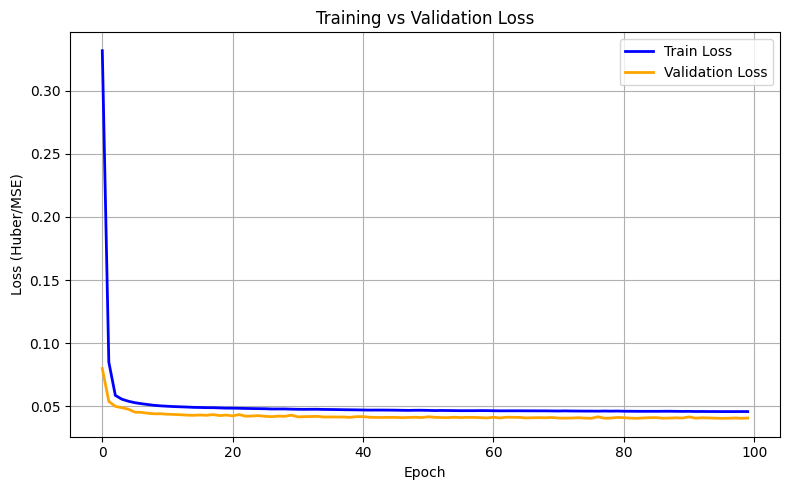

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss (Huber/MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ----------- Evaluation -----------
model.eval()
all_preds = []
all_actuals = []
with torch.no_grad():
    for xb, hb, db, mb, yb in val_dl:
        xb, hb, db, mb = xb.to(device), hb.to(device), db.to(device), mb.to(device)
        preds = model(xb, hb, db, mb)
        all_preds.append(preds.cpu())
        all_actuals.append(yb)

preds = torch.cat(all_preds)
y_true = torch.cat(all_actuals)

# Convert back to seconds
pred_seconds = torch.expm1(preds).numpy()
true_seconds = torch.expm1(y_true).numpy()

rmse = np.sqrt(mean_squared_error(true_seconds, pred_seconds))
mae = mean_absolute_error(true_seconds, pred_seconds)
r2 = r2_score(true_seconds, pred_seconds)

print(f"\n📊 Evaluation:")
print(f"RMSE (sec): {rmse:.2f} | RMSE (min): {rmse/60:.2f}")
print(f"MAE (sec): {mae:.2f} | MAE (min): {mae/60:.2f}")
print(f"R² Score: {r2:.4f}")


📊 Evaluation:
RMSE (sec): 273.04 | RMSE (min): 4.55
MAE (sec): 169.90 | MAE (min): 2.83
R² Score: 0.8159


In [39]:
# Save the model weights
torch.save(model.state_dict(), "lstm_trip_duration.pt")

In [40]:
import joblib
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

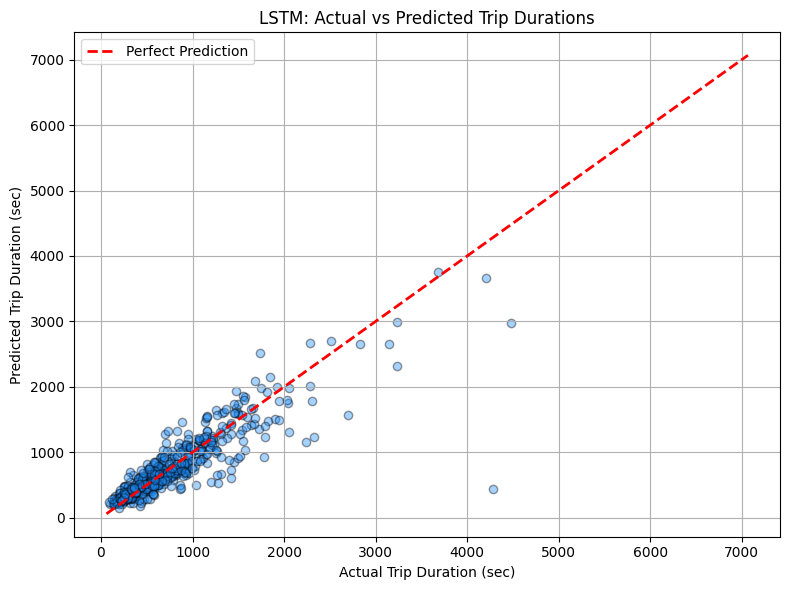

In [41]:
import matplotlib.pyplot as plt

# Plot a scatter graph
plt.figure(figsize=(8, 6))
plt.scatter(true_seconds[:500], pred_seconds[:500], alpha=0.4, color='dodgerblue', edgecolor='k')
plt.plot([true_seconds.min(), true_seconds.max()],
         [true_seconds.min(), true_seconds.max()],
         'r--', lw=2, label='Perfect Prediction')

plt.xlabel("Actual Trip Duration (sec)")
plt.ylabel("Predicted Trip Duration (sec)")
plt.title("LSTM: Actual vs Predicted Trip Durations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**XGBoost**

In [ ]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [ ]:
class PyTorchXGBoost(nn.Module):
    def __init__(self, n_estimators=100, max_depth=6, early_stopping_rounds=20, **kwargs):
        super().__init__()
        self.early_stopping_rounds = early_stopping_rounds

        self.params = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'n_jobs': -1,
            'verbosity': 0,
        }
        self.params.update(kwargs)
        self.xgb = None
        self.is_fitted = False

    def forward(self, x):
        if not self.is_fitted:
            return torch.zeros((x.shape[0], 1), device=x.device)
        return torch.tensor(
            self.xgb.predict(x.detach().cpu().numpy()).reshape(-1, 1),
            dtype=torch.float32, device=x.device
        )

    def fit(self, x_train, y_train, x_val=None, y_val=None):
        self.xgb = xgb.XGBRegressor(
            **self.params,
            early_stopping_rounds=20
        )

        x_train_np = x_train if isinstance(x_train, np.ndarray) else x_train.detach().cpu().numpy()
        y_train_np = y_train if isinstance(y_train, np.ndarray) else y_train.detach().cpu().numpy().ravel()

        if x_val is not None and y_val is not None:
            x_val_np = x_val if isinstance(x_val, np.ndarray) else x_val.detach().cpu().numpy()
            y_val_np = y_val if isinstance(y_val, np.ndarray) else y_val.detach().cpu().numpy().ravel()

            self.xgb.fit(
                x_train_np,
                y_train_np,
                eval_set=[(x_val_np, y_val_np)],
                verbose=False
            )
        else:
            self.xgb.fit(x_train_np, y_train_np)

        self.is_fitted = True

    def predict(self, x):
        x_np = x if isinstance(x, np.ndarray) else x.detach().cpu().numpy()
        return self.xgb.predict(x_np)

In [ ]:
# Log-transform y BEFORE splitting
y_train_log = np.log1p(y_train.ravel())

# 90/10 split for early stopping
X_train_main, X_valid, y_train_main, y_valid = train_test_split(
    X_train_scaled, y_train_log, test_size=0.1, random_state=42
)

best_model = None
best_rmse = float("inf")

def objective(trial):
    global best_model, best_rmse  # so we can access outside

    params = {
        "n_estimators": 500,
        "max_depth": 8,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "objective": "reg:squarederror",
        "tree_method": "hist",
        "eval_metric": "rmse",
        "n_jobs": -1
    }

    model = PyTorchXGBoost(**params)
    model.fit(
        X_train_main, y_train_main,
        x_val=X_valid, y_val=y_valid,
    )

    preds = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(np.expm1(y_valid), np.expm1(preds)))

    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model

    return rmse

In [ ]:
import optuna
from tqdm import tqdm

study = optuna.create_study(direction="minimize")
N_TRIALS = 30

for _ in tqdm(range(N_TRIALS), desc="Optimizing with Optuna"):
    study.optimize(objective, n_trials=1, catch=(Exception,))

[I 2025-06-19 17:51:16,701] A new study created in memory with name: no-name-5d6b4cfd-6a07-4c14-8392-1a44e73f15ea
Optimizing with Optuna: 100%|██████████| 30/30 [05:39<00:00, 11.30s/it]


In [ ]:
# Predict with best_model
val_preds_log = best_model.predict(X_valid)
val_preds_sec = np.expm1(val_preds_log)
y_val_sec = np.expm1(y_valid)

rmse = np.sqrt(mean_squared_error(y_val_sec, val_preds_sec))
mae = mean_absolute_error(y_val_sec, val_preds_sec)
r2 = r2_score(y_val_sec, val_preds_sec)

print(f"\n📊 Final XGBoost Evaluation (Best Saved Model):")
print(f"RMSE: {rmse:.2f} sec | {rmse/60:.2f} min")
print(f"MAE : {mae:.2f} sec | {mae/60:.2f} min")
print(f"R²  : {r2:.4f}")


📊 Final XGBoost Evaluation (Best Saved Model):
RMSE: 265.95 sec | 4.43 min
MAE : 165.78 sec | 2.76 min
R²  : 0.8260


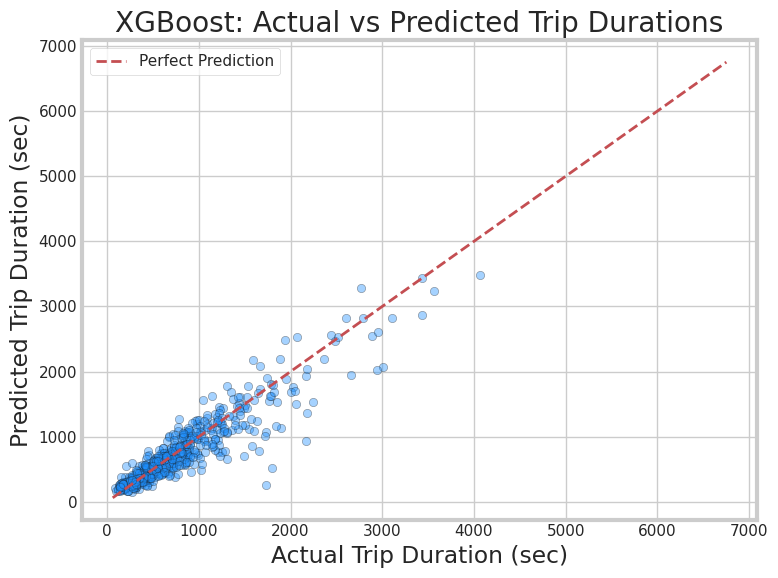

In [ ]:
import matplotlib.pyplot as plt

# Use predictions from your best_model
val_preds_log = best_model.predict(X_valid)
val_preds_sec = np.expm1(val_preds_log)  # back-transform log
y_val_sec = np.expm1(y_valid)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_val_sec[:500], val_preds_sec[:500], alpha=0.4, color='dodgerblue', edgecolor='k')

# Add perfect prediction line
min_val = min(y_val_sec.min(), val_preds_sec.min())
max_val = max(y_val_sec.max(), val_preds_sec.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel("Actual Trip Duration (sec)")
plt.ylabel("Predicted Trip Duration (sec)")
plt.title("XGBoost: Actual vs Predicted Trip Durations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Random Forest**

In [ ]:
import numpy as np
import torch
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
class PyTorchRandomForest(nn.Module):
    def __init__(self, rf_model=None, n_estimators=100, max_depth=10):
        super().__init__()
        if rf_model is not None:
            self.rf = rf_model
            self.is_fitted = True
        else:
            self.rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)
            self.is_fitted = False

    def forward(self, x):
        if not self.is_fitted:
            return torch.zeros((x.shape[0], 1), dtype=torch.float32)
        preds = self.rf.predict(x.detach().cpu().numpy()).reshape(-1, 1)
        return torch.tensor(preds, dtype=torch.float32)

    def fit(self, x, y):
        self.rf.fit(x.detach().cpu().numpy(), y.detach().cpu().numpy().ravel())
        self.is_fitted = True

In [ ]:
# ----------------------------
# Define param grid
# ----------------------------
param_grid = {
    "n_estimators": [100],
    "max_depth": [10],
    "min_samples_leaf": [1, 3, 5],
    "max_features": ['sqrt', 'log2', None]
}

grid = list(ParameterGrid(param_grid))
print(f"Total combinations: {len(grid)}")

# ----------------------------
# Convert to NumPy
# ----------------------------
X_train_np = X_train_t.cpu().numpy()
y_train_np = y_train_t.cpu().numpy().ravel()

In [ ]:
# ----------------------------
# Grid Search Manually
# ----------------------------
best_rmse = float('inf')
best_model = None
best_params = None

for params in tqdm(grid, desc="Grid Search"):
    model = RandomForestRegressor(**params, n_jobs=-1, random_state=42)
    model.fit(X_train_np, y_train_np)

    # 🔁 Evaluate on validation set (log scale)
    val_preds_log = model.predict(X_val_t.cpu().numpy())

    # ✅ Convert both predictions and targets back from log1p
    val_preds = np.expm1(val_preds_log)
    actuals = np.expm1(y_val_t.cpu().numpy())

    rmse = np.sqrt(mean_squared_error(actuals, val_preds))

    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model
        best_params = params

print(f"\n✅ Best Params: {best_params}")
print(f"📉 Best RMSE on Validation Set: {best_rmse:.2f} sec ({best_rmse / 60:.2f} min)")

In [ ]:
# After grid search
rf_model = PyTorchRandomForest(rf_model=best_model)

with torch.no_grad():
    rf_preds_log = rf_model(X_val_t)
    rf_preds_np = torch.expm1(rf_preds_log.squeeze()).cpu().numpy()
    actuals_np = torch.expm1(y_val_t).cpu().numpy()

# Evaluation
rmse = np.sqrt(mean_squared_error(actuals_np, rf_preds_np))
mae = mean_absolute_error(actuals_np, rf_preds_np)
r2 = r2_score(actuals_np, rf_preds_np)

print("\n📊 Evaluation Metrics (Best Random Forest):")
print(f"RMSE : {rmse:.2f} sec ({rmse / 60:.2f} min)")
print(f"MAE  : {mae:.2f} sec ({mae / 60:.2f} min)")
print(f"R²   : {r2:.4f}")

In [ ]:
# ----------------------------
# Scatter Plot
# ----------------------------
plt.figure(figsize=(8, 5))
plt.scatter(actuals_np, rf_preds_np, alpha=0.3, color='blue', edgecolor='k')
plt.plot([actuals_np.min(), actuals_np.max()], [actuals_np.min(), actuals_np.max()], 'r--')
plt.xlabel("Actual Trip Duration (sec)")
plt.ylabel("Predicted Trip Duration (sec)")
plt.title("🎯 Random Forest - Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#Feature Importance
importances = rf_model.rf.feature_importances_
indices = np.argsort(importances)[::-1]

# 🎨 Plot
plt.figure(figsize=(10, 6))
plt.title("📊 Feature Importances (Random Forest)")
plt.bar(range(len(importances)), importances[indices], color='skyblue', edgecolor='k')
plt.xticks(range(len(importances)), np.array(features)[indices], rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 🧾 Print Sorted Importances
print("🔍 Feature Importances (Descending Order):\n")
for i in indices:
    print(f"{features[i]:<25} : {importances[i]:.4f}")
